In [25]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load COPX Data

In [49]:
copx = yf.Ticker("COPX").history(period="max", interval="1d").reset_index()# yf.Ticker("COPX").history(period="1y", interval="1h")
copx = copx.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
copx['Date'] = pd.to_datetime(copx['Date'].dt.date)
copx = copx.sort_values(by='Date')
copx.head(3)

,Date,Open,High,Low,Close,Volume
0,2010-04-20,33.153594,33.153594,32.597325,32.664078,1933
1,2010-04-21,32.486067,32.708574,32.063303,32.152306,2900
2,2010-04-22,32.018802,32.018802,31.529286,31.974302,3600


## Feature Engineering

In [51]:
# High and Low as a percentage of Open
copx['High/Open(%)'] = copx['High']/ copx['Open']
copx['Low/Open(%)'] = copx['Low'] / copx['Open']

# Daily return based on Close
copx['Daily Return'] = copx['Close'].pct_change()  

# Date features
copx['Day of Week'] = copx['Date'].dt.day_name()
copx['Month'] = copx['Date'].dt.month
copx['Year'] = copx['Date'].dt.year

# Lag features
LAGS_DAY = [1, 2, 3, 4, 5, 10, 15, 20]
for LAG_DAY in LAGS_DAY:
    copx[f'High/Open(%) [{LAG_DAY} day]'] = copx['High/Open(%)'].shift(LAG_DAY)
    copx[f'Low/Open(%) [{LAG_DAY} day]'] = copx['Low/Open(%)'].shift(LAG_DAY)

# Moving Averages
copx['MA5'] = copx['Close'].shift(1).rolling(window = 5).mean()
copx['MA10'] = copx['Close'].shift(1).rolling(window = 10).mean()
copx['MA20'] = copx['Close'].shift(1).rolling(window = 20).mean()
copx['MA100'] = copx['Close'].shift(1).rolling(window = 100).mean()


copx = copx.dropna().reset_index()
copx.tail(3)

,index,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,...,High/Open(%) [10 day],Low/Open(%) [10 day],High/Open(%) [15 day],Low/Open(%) [15 day],High/Open(%) [20 day],Low/Open(%) [20 day],MA5,MA10,MA20,MA100
3581,3681,2024-12-03,43.090000,43.349998,42.529999,42.740002,1190100,1.006034,0.987004,0.009447,...,1.024515,0.999272,1.002754,0.986003,1.014151,0.997978,42.296001,42.447001,42.8815,43.4317
3582,3682,2024-12-04,42.720001,42.919998,42.360001,42.500000,873600,1.004682,0.991573,-0.005615,...,1.019943,0.996439,1.002844,0.978436,1.013319,0.997336,42.350001,42.503001,42.7930,43.3794
3583,3683,2024-12-05,42.380001,42.900002,42.299999,42.720001,1066388,1.012270,0.998112,0.005176,...,1.009405,0.998354,1.005037,0.979611,1.009195,0.979540,42.478001,42.463000,42.6355,43.3335


### Using other ETFs

- First Quantum Minerals Ltd. (FM.TO)
- Lundin Mining Corporation (LUN.TO)
- Capstone Copper Corp. (CS.TO)
- Boliden AB (BOL.ST)
- Ivanhoe Mines Ltd. (IVN.TO)
- Glencore plc (GLEN.L)
- Southern Copper Corporation (SCCO)
- Teck Resources Limited (TECK.B.TO)
- Freeport-McMoRan Inc. (FCX)
- BHP Group Limited (BHP.AX)

In [ ]:
tickers = ['FM.TO', 'LUN.TO', 'CS.TO', 'BOL.ST', 'IVN.TO'] 
LAG_DAYS = [1, 2, 3, 4, 5]
for ticker in tickers:
    data =  yf.Ticker(ticker).history(period="max", interval="1d").reset_index()
    data['Date'] = pd.to_datetime(data['Date'].dt.date)
    data = data.sort_values(by='Date')
    for LAG_DAY in LAG_DAYS:
        feature1 = f'{ticker} Daily Return [{LAG_DAY} day]'
        feature2 = f'{ticker} High/Open(%) [{LAG_DAY} day]'
        data[feature1] = data['Close'].pct_change().shift(LAG_DAY)
        data[feature2] = (data['High'] / data['Open']).shift(LAG_DAY)
        
        features = data[['Date', feature1, feature2]]
        copx = pd.merge(copx, features, on='Date', how='left')
        
copx

,index,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,...,BOL.ST Daily Return [1 day]_y,BOL.ST High/Open(%) [1 day]_y,BOL.ST Daily Return [2 day]_y,BOL.ST High/Open(%) [2 day]_y,BOL.ST Daily Return [3 day]_y,BOL.ST High/Open(%) [3 day]_y,BOL.ST Daily Return [4 day]_y,BOL.ST High/Open(%) [4 day]_y,BOL.ST Daily Return [5 day]_y,BOL.ST High/Open(%) [5 day]_y
0,100,2010-09-10,30.372253,30.461255,30.216498,30.439005,3733,1.002930,0.994872,0.005143,...,-0.005208,1.007772,0.023454,1.033853,0.030769,1.018448,0.015625,1.015000,0.004485,1.017957
1,101,2010-09-13,31.084271,31.640539,31.017519,31.640539,3133,1.017895,0.997853,0.039474,...,-0.001571,1.019639,-0.005208,1.007772,0.023454,1.033853,0.030769,1.018448,0.015625,1.015000
2,102,2010-09-14,31.351276,32.041048,31.351276,31.707287,4133,1.022001,1.000000,0.002110,...,0.024121,1.018229,-0.001571,1.019639,-0.005208,1.007772,0.023454,1.033853,0.030769,1.018448
3,103,2010-09-15,31.596032,31.751789,31.573782,31.707287,1500,1.004930,0.999296,0.000000,...,0.012801,1.015369,0.024121,1.018229,-0.001571,1.019639,-0.005208,1.007772,0.023454,1.033853
4,104,2010-09-16,31.751802,31.863054,31.685050,31.863054,2867,1.003504,0.997898,0.004913,...,-0.002528,1.008586,0.012801,1.015369,0.024121,1.018229,-0.001571,1.019639,-0.005208,1.007772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,3679,2024-11-29,41.869999,42.630001,41.869999,42.630001,1278900,1.018151,1.000000,0.010669,...,-0.004330,1.009302,-0.000618,1.011132,-0.010098,1.005510,0.023809,1.014583,0.005354,1.005008
3580,3680,2024-12-02,42.320000,42.660000,41.919998,42.340000,1323700,1.008034,0.990548,-0.006803,...,0.010873,1.008055,-0.004330,1.009302,-0.000618,1.011132,-0.010098,1.005510,0.023809,1.014583
3581,3681,2024-12-03,43.090000,43.349998,42.529999,42.740002,1190100,1.006034,0.987004,0.009447,...,0.008912,1.034126,0.010873,1.008055,-0.004330,1.009302,-0.000618,1.011132,-0.010098,1.005510
3582,3682,2024-12-04,42.720001,42.919998,42.360001,42.500000,873600,1.004682,0.991573,-0.005615,...,0.035943,1.040724,0.008912,1.034126,0.010873,1.008055,-0.004330,1.009302,-0.000618,1.011132


## Baseline

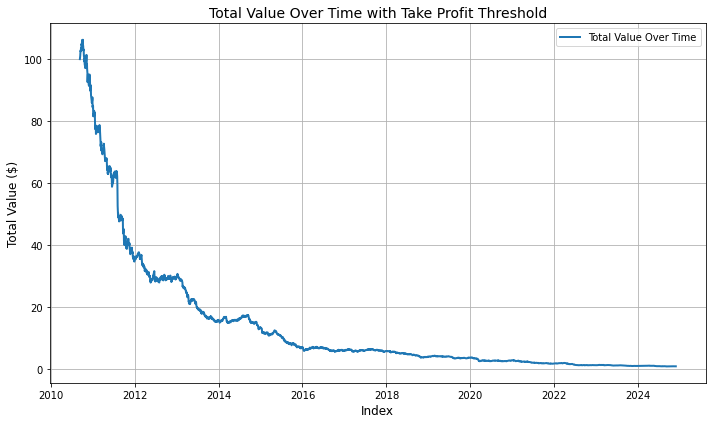

,index,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,...,High/Open(%) [15 day],Low/Open(%) [15 day],High/Open(%) [20 day],Low/Open(%) [20 day],MA5,MA10,MA20,MA100,Value Sold Per Stock,Total Value
0,100,2010-09-10 00:00:00-04:00,30.372253,30.461255,30.216498,30.439005,3733,1.002930,0.994872,0.005143,...,1.000000,0.975232,1.012235,1.000000,29.985086,28.974903,28.341870,27.250027,30.439005,100
1,101,2010-09-13 00:00:00-04:00,31.084267,31.640535,31.017515,31.640535,3133,1.017895,0.997853,0.039473,...,1.000000,0.988764,1.000000,0.994364,30.140841,29.326466,28.490950,27.227776,31.395110,101.0
2,102,2010-09-14 00:00:00-04:00,31.351279,32.041052,31.351279,31.707291,4133,1.022001,1.000000,0.002110,...,1.004026,0.991948,1.006452,1.000000,30.439000,29.702503,28.698994,27.222659,31.664792,102.01
3,103,2010-09-15 00:00:00-04:00,31.596036,31.751793,31.573786,31.707291,1500,1.004930,0.999296,0.000000,...,1.000829,0.984245,1.012480,0.999220,30.826162,30.089665,28.900364,27.219989,31.707291,102.369194
4,104,2010-09-16 00:00:00-04:00,31.751800,31.863052,31.685048,31.863052,2867,1.003504,0.997898,0.004912,...,1.019491,0.994068,1.000000,0.980769,31.155474,30.501303,29.041655,27.216206,31.863052,102.727875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,3672,2024-11-19 00:00:00-05:00,42.119999,42.959999,41.970001,42.900002,1055400,1.019943,0.996439,0.017070,...,1.000441,0.991178,1.001966,0.991263,41.492000,43.083000,43.934000,43.814200,42.541199,0.790432
3573,3673,2024-11-20 00:00:00-05:00,42.529999,42.930000,42.459999,42.529999,1196600,1.009405,0.998354,-0.008625,...,1.004270,0.991011,1.000886,0.984057,41.686000,42.808000,43.786500,43.792100,42.529999,0.790432
3574,3674,2024-11-21 00:00:00-05:00,42.529999,42.919998,42.320000,42.790001,812500,1.009170,0.995062,0.006113,...,1.003172,0.980512,1.002440,0.985803,42.018000,42.676000,43.664500,43.762700,42.790001,0.795264
3575,3675,2024-11-22 00:00:00-05:00,42.330002,42.619999,42.220001,42.590000,1120000,1.006851,0.997401,-0.004674,...,1.012220,0.999774,1.015525,0.996452,42.300000,42.309000,43.559000,43.734200,42.590000,0.800149


In [ ]:
principal = 100 # Starting dollars
take_profit_threshold = 1.01 # Can change

'''
stop_loss_threshold = 0.80 # Can change
def get_profit_loss(row):
    take_profit = row['Open'] * take_profit_threshold
    stop_loss = row['Open'] * stop_loss_threshold
    if row['Low'] <= stop_loss:
        return stop_loss
    if row['High'] >= take_profit:
        return take_profit
    
    return row['Close']
'''

# No stop loss, only take profit
def get_profit_loss(row):
    take_profit = row['Open'] * take_profit_threshold
    if row['High'] >= take_profit:
        return take_profit
    
    return row['Close']

copx['Value Sold Per Stock'] = copx.apply(get_profit_loss, axis=1)

copx['Total Value'] = None
for i in range(len(copx)):
    if i == 0:
        # The first row's Stock Value is the principal
        copx.loc[i, 'Total Value'] = principal
    else:
        # Calculate current row's Stock Value
        n_stocks = copx.loc[i - 1, 'Total Value'] / copx.loc[i, 'Open']
        copx.loc[i, 'Total Value'] = (
            n_stocks * copx.loc[i, 'Value Sold Per Stock']
        )

plt.figure(figsize=(10, 6))
plt.plot(copx['Date'].values, copx['Total Value'].values, label='Total Value Over Time', linewidth=2)

plt.title('Total Value Over Time with Take Profit Threshold', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Total Value ($)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

copx

## EDA

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

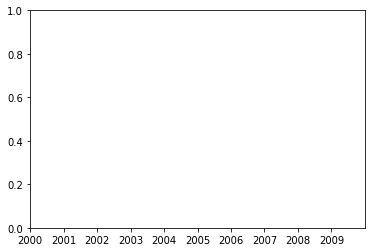

In [13]:
sns.lineplot(data=copx, x="Date", y="Close")
plt.show()

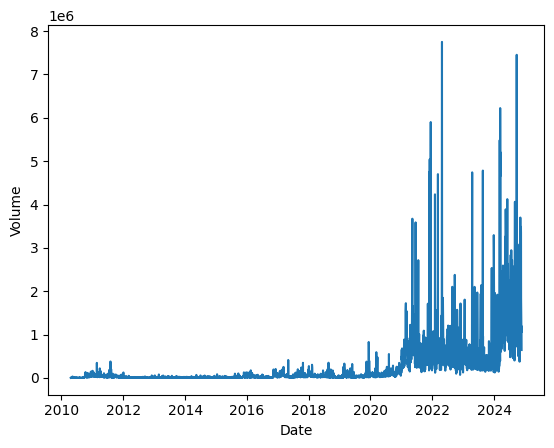

In [ ]:
sns.lineplot(data=copx, x="Date", y="Volume")
plt.show()